In [1]:
import csv
import networkx as nx
import numpy as np

# Reading files

In [2]:
# Reading CSV
G = nx.Graph()
pos, site = {}, {}

#  Getting the labels
with open('CSV/first_graph/nodes_cost266.csv', 'r') as f_node:
    reader = csv.DictReader(f_node, delimiter=';', quotechar="'")
    for row in reader:
        node = int(row['node'])
        site_node = row['site']
        x_coord, y_coord = float(row['X']), float(row['Y'])
        G.add_node(node,site=site_node)
        pos[node] = [x_coord,y_coord]
        site[node] = site_node

with open('CSV/first_graph/edges_cost266.csv', 'r') as f_edge:
    reader = csv.DictReader(f_edge, delimiter=';', quotechar="'")
    for row in reader:
        nodeA, nodeB = int(row['nodeA']), int(row['nodeB'])
        G.add_edge(nodeA,nodeB)        
        G[nodeA][nodeB]['capa'] = float(row['capa'])
        G[nodeA][nodeB]['weight'] = float(row['cost'])
        
capa = {}
for (u,v) in G.edges():
    capa[(u,v)], capa[(v,u)] = G[u][v]['capa'], G[u][v]['capa']

#  Getting the demands
K = nx.DiGraph()
with open('CSV/first_graph/demand_cost266.csv', 'r') as f_demand:
    reader = csv.DictReader(f_demand, delimiter=';', quotechar="'")
    for row in reader:
        nodeA = int(row['nodeA'])
        nodeB = int(row['nodeB'])
        if nodeA > nodeB:
            nodeA, nodeB = nodeB, nodeA
            
        K.add_edge(nodeA,nodeB)                    
        K[nodeA][nodeB]['demand'] = float(row['demand'])/25.

# Some useful information
print('The network has', G.number_of_nodes(),'nodes and', G.number_of_edges(), 'edges.')
print('There are', K.number_of_edges(),'demands.')

The network has 37 nodes and 57 edges.
There are 36 demands.


In [3]:
# Computing the shortest path satisfying a demand chosen randomly in K
n = np.random.randint(0, K.number_of_edges())
demand = list(K.edges)[n]

s_path = nx.shortest_path(G, source=demand[0], target=demand[1])
s_path_edges = zip(s_path,s_path[1:])
s_path_edges = set(s_path_edges)

w_path = nx.shortest_path(G, source=demand[0], target=demand[1], weight='weight')
w_path_edges = zip(w_path,w_path[1:])
w_path_edges = set(w_path_edges)

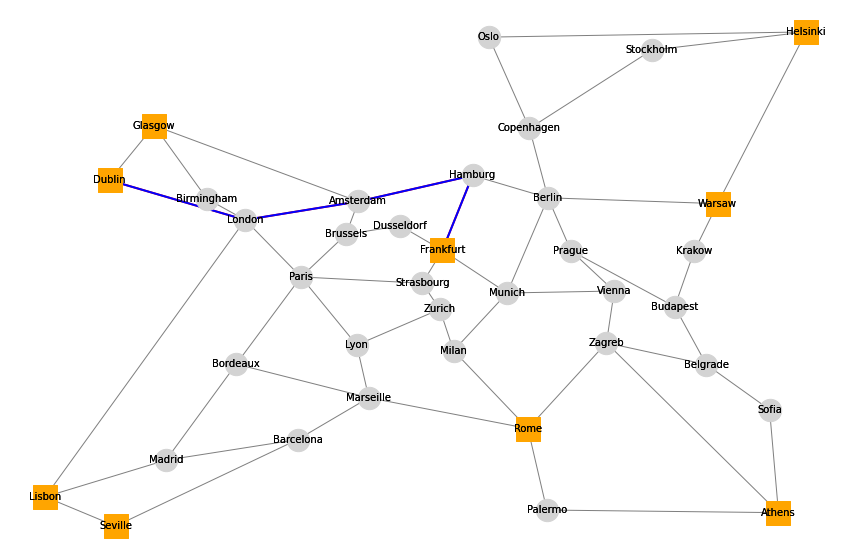

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Creating a figure
plt.figure(figsize=(15,10));
plt.axis('off')

# Plotting the network
nx.draw_networkx_labels(G,pos,labels=site,font_size=10,font_color='black')
nx.draw(G, pos=pos, node_size=500, node_color='lightgrey', edge_color='grey')

nx.draw_networkx_labels(K,pos,labels=site,font_size=10,font_color='black')  
nx.draw_networkx_nodes(K, pos=pos, node_size=600, node_color='orange',node_shape='s')

# Plotting the shortest paths without and with weights
nx.draw_networkx_edges(G,pos,edgelist=s_path_edges,edge_color='r',width=2)
nx.draw_networkx_edges(G,pos,edgelist=w_path_edges,edge_color='b',width=2)
plt.show()

[11, 19, 1, 15, 13]
[11, 14, 1, 15, 13]
[11, 19, 27, 33, 13]


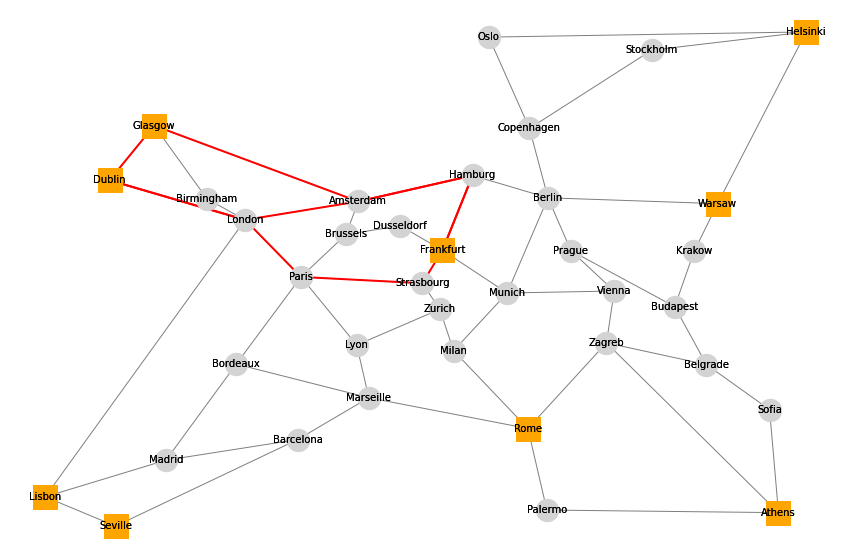

In [5]:
plt.figure(figsize=(15,10));
plt.axis('off')

nx.draw_networkx_labels(G,pos,labels=site,font_size=10,font_color='black')
nx.draw(G, pos=pos, node_size=500, node_color='lightgrey', edge_color='grey')

nx.draw_networkx_labels(K,pos,labels=site,font_size=10,font_color='black')  
nx.draw_networkx_nodes(K, pos=pos, node_size=600, node_color='orange',node_shape='s')

# Computing and plotting all unweighted shortest paths
a_paths = nx.all_shortest_paths(G, demand[0], demand[1])
for path in a_paths:
    path_edges = zip(path,path[1:])
    path_edges = set(path_edges) 
    nx.draw_networkx_edges(G,pos,edgelist=path_edges,edge_color='r',width=2)
    print(path)

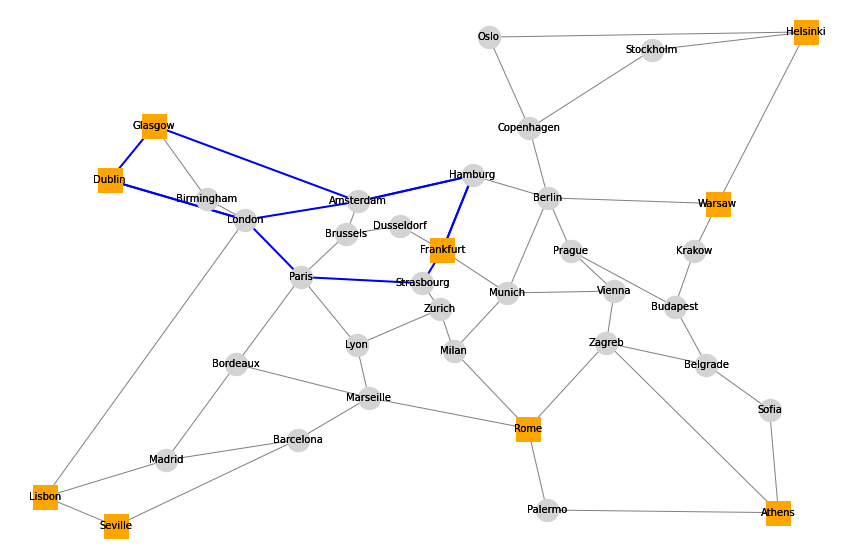

In [6]:
plt.figure(figsize=(15,10));
plt.axis('off')

nx.draw_networkx_labels(G,pos,labels=site,font_size=10,font_color='black')
nx.draw(G, pos=pos, node_size=500, node_color='lightgrey', edge_color='grey')

nx.draw_networkx_labels(K,pos,labels=site,font_size=10,font_color='black')  
nx.draw_networkx_nodes(K, pos=pos, node_size=600, node_color='orange',node_shape='s')

# Same with weighted edges
a_paths = nx.all_shortest_paths(G, demand[0], demand[1], weight='weight')
for path in a_paths:
    path_edges = zip(path,path[1:])
    path_edges = set(path_edges) 
    nx.draw_networkx_edges(G,pos,edgelist=path_edges,edge_color='b',width=2)

In [7]:
print('The demand from', G.nodes[demand[0]]['site'], 'to', G.nodes[demand[1]]['site'], 'is', K[demand[0]][demand[1]]['demand'])

The demand from Dublin to Frankfurt is 5.92


In [8]:
# Finding the minimum capacity along the shortest paths
a_paths = nx.all_shortest_paths(G, demand[0], demand[1], weight='weight')

for i, path in enumerate(a_paths):
    path_edges = zip(path,path[1:])
    path_edges = set(path_edges)
    min_capa = min(G.edges[edge]['capa'] for edge in path_edges)
    print('Capacity along path', i+1, 'is', min_capa)
    if min_capa > K[demand[0]][demand[1]]['demand']:
        print('The path can deliver the demand')
    else:
        print('The path cannot deliver the demand')
    print('-------------------------------')

Capacity along path 1 is 100.0
The path can deliver the demand
-------------------------------
Capacity along path 2 is 100.0
The path can deliver the demand
-------------------------------
Capacity along path 3 is 100.0
The path can deliver the demand
-------------------------------


In [9]:
def IGP(G, K, i):
    """
    Given a graph G, demands K and demand number i returns the flows and the maximum load
    """
    
    # Initiate the constants
    dem = list(K.edges)[i]
    dem_val = K[dem[0]][dem[1]]['demand']
    flows, load = {}, 0
    
    # Compute shortest paths
    a_paths = nx.all_shortest_paths(G, dem[0], dem[1], weight='weight')
    a_paths = list(a_paths)
    n_paths = len(a_paths)
    
    for path in a_paths:
        for i in range(len(path)-1):
            if (path[i], path[i+1]) in flows:
                flows[(path[i], path[i+1])] += 1/n_paths
            else:
                flows[(path[i], path[i+1])] = 1/n_paths
    
    # Compute the maximum load
    M = 0
    for (u,v) in flows:
        M = flows[(u,v)]/G[u][v]['capa']
        if M > load:
            load = M
    return flows, load*dem_val

In [10]:
def IGP_tot(G, K):
    """
    Returns the maximum load in graph G amongst all demands K with respect to IGP
    """
    flows_tot, load = {}, 0
    for i in range(K.number_of_edges()):
        flows, M = IGP(G, K, i)
        flows_tot[i] = flows
        if M > load:
            load = M
    return flows_tot, load

In [11]:
flows, load = IGP_tot(G,K)

In [12]:
print(load)

0.632


In [13]:
def forward_table(G, K, i):
    """
    Given a graph G, demands K and demand number i 
    returns the forward table amongst shortest paths in G satisfying the demand
    """
    dem = list(K.edges)[i]
    dem_val = K[dem[0]][dem[1]]['demand']
    a_paths = list(nx.all_shortest_paths(G, dem[0], dem[1], weight='weight'))
    
    table = {}
    for path in a_paths:
        for i in range(len(path)-1):
            if path[i] in table:
                if path[i+1] not in table[path[i]]:
                    table[path[i]].append(path[i+1])
            else:
                table[path[i]] = [path[i+1]]
    table[dem[1]] = ['t']
    return table

In [14]:
forward_table(G, K, 8)

{11: [19, 14],
 19: [1, 27],
 1: [15],
 15: [13],
 14: [1],
 27: [33],
 33: [13],
 13: ['t']}

In [15]:
def backward_table(G, K, i):
    """
    Given a graph G, demands K and demand number i 
    returns the forward table amongst shortest paths in G satisfying the demand
    """
    dem = list(K.edges)[i]
    dem_val = K[dem[0]][dem[1]]['demand']
    a_paths = list(nx.all_shortest_paths(G, dem[0], dem[1], weight='weight'))
    
    table = {}
    table[dem[0]] = ['s']
    for path in a_paths:
        for i in range(len(path)-1):
            if path[i+1] in table:
                if path[i] not in table[path[i+1]]:
                    table[path[i+1]].append(path[i])
            else:
                table[path[i+1]] = [path[i]]
    return table

In [16]:
backward_table(G, K, 8)

{11: ['s'],
 19: [11],
 1: [19, 14],
 15: [1],
 13: [15, 33],
 14: [11],
 27: [19],
 33: [27]}

In [17]:
def ECMP(G, K, i):
    
    """
    Given a grapg G, demands K and demand number i
    returns the ECMP satisfying the demands on the shortest paths
    """
    # Compute the forward and backward tables
    f_table = forward_table(G, K, i)
    b_table = backward_table(G, K, i)
    
    # Initiate the constants
    dem = list(K.edges)[i]
    dem_val = K[dem[0]][dem[1]]['demand']
    flow, load = {}, 0
    
    # Computing the flow branchements
    flow[('s', list(f_table)[0])] = 1
    for nodeA in f_table:
        for nodeB in f_table[nodeA]:
            flow[(nodeA, nodeB)] = 0
    for nodeA in f_table:
        for nodeB in f_table[nodeA]:
            in_flow = 0
            for nodeC in b_table[nodeA]:
                in_flow += flow[(nodeC, nodeA)]
            flow[(nodeA, nodeB)] = in_flow/len(f_table[nodeA])
    if flow[(list(f_table)[-1], 't')] != 1:
        for nodeA in f_table:
            for nodeB in f_table[nodeA]:
                in_flow = 0
                for nodeC in b_table[nodeA]:
                    in_flow += flow[(nodeC, nodeA)]
                flow[(nodeA, nodeB)] = in_flow/len(f_table[nodeA])
                
    del flow[('s', list(f_table)[0])]
    del flow[(list(f_table)[-1], 't')]

   
    # Compute the maximum load
    M = 0
    for (u,v) in flow:
        M = flow[(u,v)]/G[u][v]['capa']
        if M > load:
            load = M
    return flow, load*dem_val

In [18]:
ECMP(G, K, 8)

({(11, 19): 0.5,
  (11, 14): 0.5,
  (19, 1): 0.25,
  (19, 27): 0.25,
  (1, 15): 0.75,
  (15, 13): 0.75,
  (14, 1): 0.5,
  (27, 33): 0.25,
  (33, 13): 0.25},
 0.044399999999999995)

In [19]:
def ECMP_tot(G, K):
    """
    Returns the maximum load in graph G amongst all demands K with respect to ECMP
    """
    flows_tot, load = {}, 0
    for i in range(K.number_of_edges()):
        flows, M = ECMP(G, K, i)
        flows_tot[i] = flows
        if M > load:
            load = M
    return flows_tot, load 

In [20]:
flows, load_ECMP = ECMP_tot(G, K)

In [21]:
print(load_ECMP)

0.632
